In [ ]:
import tensorflow as tf
import cv2
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train_path = '/content/drive/MyDrive/train_class/'

In [ ]:
Classes = ["0","1","2","3","4","5","6"]
img_size = 224

In [ ]:
training_Data = []
def create_training_Data():
  for category in Classes:
    path = os.path.join(train_path, category)
    class_num = Classes.index(category)
    for img in os.listdir(path):
      img_array = cv2.imread(os.path.join(path, img))
      new_array = cv2.resize(img_array, (img_size, img_size))
      training_Data.append([new_array, class_num])

In [ ]:
create_training_Data()

In [ ]:
random.shuffle(training_Data)

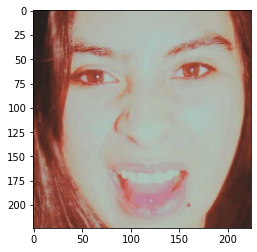

In [ ]:
plt.imshow(cv2.cvtColor(training_Data[7][0], cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
X_train = []
y_train = []
for features, label in training_Data:
    X_train.append(features)
    y_train.append(label)
X_train = np.array(X_train).reshape(-1, img_size, img_size, 3)

In [ ]:
print(X_train.shape)

(3539, 224, 224, 3)


In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
model =tf.keras.applications.MobileNetV2()

In [ ]:
base_input = model.layers[0].input

In [ ]:
base_output = model.layers[-2].output

In [ ]:
final_output = layers.Dense(128)(base_output)
final_output = layers.Activation('relu')(final_output)
final_output = layers.Dense(64)(final_output)
final_output = layers.Activation('relu')(final_output)
final_output = layers.Dense(32)(final_output)
final_output = layers.Activation('relu')(final_output)
final_output = layers.Dense(16)(final_output)
final_output = layers.Activation('relu')(final_output)
final_output = layers.Dense(8)(final_output)
final_output = layers.Activation('relu')(final_output)
final_output = layers.Dense(7, activation='softmax')(final_output)

In [ ]:
new_model = keras.Model(inputs = base_input, outputs = final_output)

In [ ]:
new_model.compile(loss="sparse_categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"])

In [ ]:
X_train = np.array(X_train)
y_train = np.array(y_train)

In [ ]:
history = new_model.fit(X_train, y_train, epochs = 25)

Epoch 1/25
111/111 [==============================] - 26s 197ms/step - loss: 1.7962 - accuracy: 0.2693
Epoch 2/25
111/111 [==============================] - 22s 200ms/step - loss: 1.6270 - accuracy: 0.3371
Epoch 3/25
111/111 [==============================] - 22s 203ms/step - loss: 1.5367 - accuracy: 0.3586
Epoch 4/25
111/111 [==============================] - 22s 203ms/step - loss: 1.4920 - accuracy: 0.3851
Epoch 5/25
111/111 [==============================] - 23s 204ms/step - loss: 1.4311 - accuracy: 0.4075
Epoch 6/25
111/111 [==============================] - 22s 202ms/step - loss: 1.3692 - accuracy: 0.4397
Epoch 7/25
111/111 [==============================] - 23s 204ms/step - loss: 1.2898 - accuracy: 0.4611
Epoch 8/25
111/111 [==============================] - 23s 204ms/step - loss: 1.2067 - accuracy: 0.5066
Epoch 9/25
111/111 [==============================] - 23s 206ms/step - loss: 1.1579 - accuracy: 0.5372
Epoch 10/25
111/111 [==============================] - 23s 203ms/step - l

In [ ]:
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time

In [ ]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

In [ ]:
face_cascade = cv2.CascadeClassifier(cv2.samples.findFile(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'))

In [ ]:
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)

  # get photo data
  data = eval_js('takePhoto({})'.format(quality))
  # get OpenCV format image
  img = js_to_image(data)
  # save image
  cv2.imwrite(filename, img)

  return filename

<IPython.core.display.Javascript object>

Saved to photo.jpg


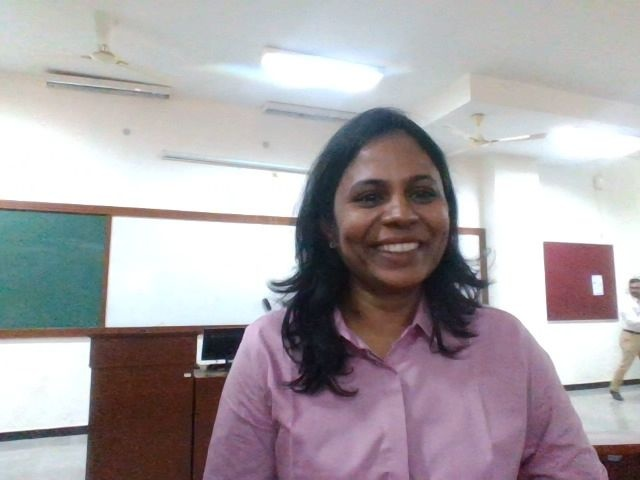

1/1 [==============================] - 0s 20ms/step


In [ ]:
try:
  filename = take_photo('photo.jpg')
  print('Saved to {}'.format(filename))
  display(Image(filename))
except Exception as err:
  print(str(err))

img = cv2.imread('/content/photo.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
faces = face_cascade.detectMultiScale(gray, 1.1, 4)
for (x, y, w, h) in faces:
    cv2.rectangle(img, (x, y), (x+w, y+h), (0, 0, 255), 2)
    faces = img[y:y + h, x:x + w]
    cv2.imwrite('face.jpg', faces)

img_array = cv2.imread('/content/face.jpg')
new_array = cv2.resize(img_array, (img_size, img_size))
new_array = new_array.reshape(-1, img_size, img_size, 3)
prediction = new_model.predict(new_array)
category = np.argmax(prediction)

In [ ]:
from IPython.display import Javascript
def recom(category):
  i = 0
  if i == 0:
    url = 'http://localhost:8000/AIProject/frontEnd/index2.html'
    display(Javascript('window.open("{url}");'.format(url=url)))

In [ ]:
def recommendation(category):
  if category in [0, 1]:
    url = 'http://localhost:8000/AIProject/frontEnd/index2.html'
    display(Javascript('window.open("{url}");'.format(url=url)))
  if category in [2, 3, 4, 5, 6]:
    url = 'http://localhost:8000/AIProject/frontEnd/index1.html'
    display(Javascript('window.open("{url}");'.format(url=url)))

In [ ]:
recom(category)

<IPython.core.display.Javascript object>

In [ ]:
recommendation(category)